In [2]:
# Cell 1: Install dependencies (add PyTorch for deep learning)
%pip install numpy pandas transformers scikit-learn faiss-cpu gensim datasets networkx matplotlib seaborn tqdm ipython sentencepiece torch torchvision torchaudio ipywidgets pymongo


  Using cached pymongo-4.11.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (22 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
Using cached pymongo-4.11.1-cp311-cp311-macosx_11_0_arm64.whl (840 kB)
Using cached dnspython-2.7.0-py3-none-any.whl (313 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cell 2: Import libraries (add PyTorch modules)
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import networkx as nx
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets
import torch
import torch.nn as nn
import torch.optim as optim
from pymongo import MongoClient
%matplotlib inline

In [4]:
# Cell 3: Load and preprocess synthetic data
print("Loading synthetic dataset...")
dataset = load_dataset("ilsilfverskiold/linkedin_profiles_synthetic")
df = pd.DataFrame(dataset['train'])
df['user_type'] = np.random.choice(['student', 'alumni', 'officer'], len(df))
display(df.head())


Loading synthetic dataset...


,FirstName,LastName,Headline,Location,About Me,Experience,Education,Skills,Certifications,Recommendations,...,embeddings_nv-embedqa-e5-v5,embeddings_bge-m3,embeddings_arctic-embed-l,embeddings_mistral-7b-v2,embeddings_gte-large-en-v1.5,embeddings_text-embedding-ada-002,embeddings_text-embedding-3-small,embeddings_voyage-3,embeddings_mxbai-embed-large-v1,user_type
0,Zachariah,Witting,Augmented Reality Developer | Creating Immersi...,"Zurich, Switzerland",Dedicated and innovative AR developer with a p...,"Senior AR Developer | Pixelloid | Zurich, Swit...",ETH Zurich | Bachelor of Science in Computer S...,Unity; ARKit; ARCore; C#; Java; JavaScript; We...,Certified AR Developer | Unity Technologies | ...,"Benjamin Ryder | Lead Developer, Breadwinner S...",...,"[-0.0040283203125, -0.0135040283203125, -0.013...","[-0.0714111328125, -0.032958984375, 0.00956726...","[0.0011386871337890625, -0.0296630859375, 0.01...","[0.0209808349609375, 0.00884246826171875, -0.0...","[0.0010018084, 0.03207807, 0.0020768428, 0.008...","[-0.012569249, -0.0014929766, -0.0005262406, -...","[-0.03209501, -0.0011106498, 0.024465062, 0.02...","[-0.010514396, -0.054661196, 0.0013718046, 0.0...","[0.016271759, 0.008558619, -0.06318841, -0.038...",alumni
1,Yvonne,Hofmann,UI Designer | Crafting Human-Centered Digital ...,"Zurich, Switzerland",As a UI Designer with a passion for human-cent...,"Senior UI Designer at EVONIK | EVONIK | Essen,...",Hochschule für Gestaltung und Kunst | Bachelor...,User Experience Design; Visual Design; Human-C...,Certified UX Designer | Nielsen Norman Group |...,Yvonne is a talented and dedicated designer wh...,...,"[0.010345458984375, -0.04058837890625, 0.04122...","[-0.0811767578125, -0.048858642578125, -0.0326...","[0.00482177734375, -0.0362548828125, 0.0547180...","[0.0004520416259765625, 0.022918701171875, -0....","[0.01612412, -0.012229308, -0.0012095612, 0.03...","[-0.007296344, -0.036226414, -0.012892894, 5.2...","[-0.02247679, -0.00025442478, 0.024274934, 0.0...","[-0.015455144, -0.0051680231, 0.028300855, 0.0...","[-0.041409347, -0.014491842, -0.070636116, -0....",officer
2,Yves,Laurent,Co-Founder AI Product | Transforming Industrie...,"Zurich, Switzerland",Results-driven technology entrepreneur with a ...,Mindera | Co-Founder and Head of AI Product | ...,EPFL | Master of Science in Computer Science |...,AI Strategy; Machine Learning; Deep Learning; ...,AWS Certified Developer - Associate; Google Cl...,Pierre Dupont | CTO at Mindera | Yves has been...,...,"[-0.0260467529296875, 0.009124755859375, -0.03...","[-0.05426025390625, -0.0178375244140625, -0.02...","[-0.023040771484375, -0.006618499755859375, -0...","[0.00290679931640625, -0.0150604248046875, -0....","[-0.0064060865, 0.038315836, -0.01249036, 0.01...","[0.0013401911, -0.02315128, 0.021068081, -0.01...","[0.014104838, -0.02102309, 0.028816335, 0.0099...","[0.0065766545, -0.057736553, 0.026976572, 0.04...","[0.012321422, 0.012636202, -0.02650155, -0.029...",student
3,Yves,Thibault,NLP Specialist | Helping businesses unlock ins...,"Zurich, Switzerland",I'm a seasoned NLP professional with a passion...,"Senior NLP Engineer, IBM Research | IBM | Zuri...",École Polytechnique Fédérale de Lausanne (EPFL...,NLP; Deep Learning; Natural Language Generatio...,Google Cloud Certified - Professional Data Eng...,"Dr. Maria Rodriguez, Research Director, IBM | ...",...,"[-0.0144195556640625, -0.0172271728515625, -0....","[-0.06982421875, -0.0027370452880859375, 0.013...","[-0.00853729248046875, -0.02984619140625, 0.02...","[0.008544921875, -0.005107879638671875, -0.029...","[-0.0046507316, 0.044952057, -0.041179296, -0....","[-0.022266217, 0.008473045, 0.034567323, -0.01...","[-0.0656291, -0.017954687, 0.049091894, -0.027...","[0.002940885, -0.05102396, 0.050508436, 0.0008...","[-0.0009468875, -0.010518525, -0.059485085, -0...",student
4,Yves,Bonnard,Advertising Manager | Driving Brand Growth Thr...,"Zurich, Switzerland",Results-driven Advertising Manager with 8+ yea...,Advertising 

In [5]:
# Cell 4: T5 setup for NLP (optimized with MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
model.eval()

def summarize_profiles_batch(texts, batch_size=32):
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        input_texts = [f"summarize: {text}" for text in batch_texts]
        inputs = tokenizer(input_texts, return_tensors="pt", max_length=256, truncation=True, padding=True).to(device)
        with torch.no_grad():
            summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=1, early_stopping=True)
        batch_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        summaries.extend(batch_summaries)
    return summaries

print("Summarizing profiles...")
headlines = df['Headline'].tolist()
df['summary'] = summarize_profiles_batch(headlines, batch_size=32)
display(df[['Headline', 'summary']].head())



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Summarizing profiles...


/opt/homebrew/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


,Headline,summary
0,Augmented Reality Developer | Creating Immersi...,
1,UI Designer | Crafting Human-Centered Digital ...,
2,Co-Founder AI Product | Transforming Industrie...,
3,NLP Specialist | Helping businesses unlock ins...,
4,Advertising Manager | Driving Brand Growth Thr...,


In [6]:
# Cell 5: Generate embeddings and save artifacts
def generate_t5_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model.encoder(**inputs).last_hidden_state.mean(dim=1).detach().cpu().numpy()
    return outputs[0]

print("Generating T5 embeddings...")
df['headline_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['Headline'])]
df['summary_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['summary'])]
df['combined_embedding'] = df.apply(lambda row: np.mean([row['headline_embedding'], row['summary_embedding']], axis=0), axis=1)
all_embeddings = normalize(np.stack(df['combined_embedding'].values))
index = faiss.IndexFlatL2(all_embeddings.shape[1])
index.add(all_embeddings)

import pickle
with open('faiss_index.pkl', 'wb') as f:
    pickle.dump(index, f)
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)
with open('df.pkl', 'wb') as f:
    pickle.dump(df[['FirstName', 'LastName', 'user_type', 'Headline', 'summary']], f)


Generating T5 embeddings...


  0%|          | 0/6904 [00:00<?, ?it/s]

  0%|          | 0/6904 [00:00<?, ?it/s]

In [7]:
# Cell 6: Deep Learning Model (Neural Collaborative Filtering)
class NCF(nn.Module):
    def __init__(self, embedding_dim=512, hidden_dim=128):
        super(NCF, self).__init__()
        self.user_embedding = nn.Parameter(torch.randn(6904, embedding_dim))  # Synthetic users
        self.fc1 = nn.Linear(embedding_dim * 3, hidden_dim)  # Prompt, user, candidate embeddings
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, user_idx, prompt_embedding, candidate_embedding):
        user_emb = self.user_embedding[user_idx]
        combined = torch.cat([prompt_embedding, user_emb, candidate_embedding], dim=-1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        score = self.fc2(x)
        return score

ncf_model = NCF().to(device)
optimizer = optim.Adam(ncf_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Simulate training data (synthetic interactions)
np.random.seed(42)
user_indices = np.random.randint(0, 6904, size=10000)
candidate_indices = np.random.randint(0, 6904, size=10000)
ratings = np.random.uniform(0, 1, size=10000)  # Simulated ratings

# Training loop
print("Training NCF model...")
for epoch in range(5):
    total_loss = 0
    for user_idx, cand_idx, rating in zip(user_indices, candidate_indices, ratings):
        prompt_emb = torch.tensor(all_embeddings[user_idx], dtype=torch.float32).to(device)  # Dummy prompt
        cand_emb = torch.tensor(all_embeddings[cand_idx], dtype=torch.float32).to(device)
        pred = ncf_model(user_idx, prompt_emb, cand_emb)
        loss = criterion(pred, torch.tensor([rating], dtype=torch.float32).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(user_indices):.4f}")
torch.save(ncf_model.state_dict(), 'ncf_model.pth')



Training NCF model...
Epoch 1, Loss: 0.1010
Epoch 2, Loss: 0.0861
Epoch 3, Loss: 0.0769
Epoch 4, Loss: 0.0696
Epoch 5, Loss: 0.0663


In [16]:
# Cell 7: Traditional recommendation (moved from original Cell 9)
def analyze_prompt(prompt):
    input_text = f"extract_keywords: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    output_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)
    keywords = tokenizer.decode(output_ids[0], skip_special_tokens=True).split(", ")
    prompt_embedding = generate_t5_embeddings(prompt)
    return keywords, prompt_embedding

def recommend_with_prompt(user_idx, prompt, top_n=5):
    prompt_keywords, prompt_embedding = analyze_prompt(prompt)
    user_embedding = all_embeddings[user_idx]
    user_type = df.iloc[user_idx]['user_type']
    
    distances, indices = index.search(prompt_embedding.reshape(1, -1), top_n + 10)
    candidate_indices = indices[0][1:]
    candidates = df.iloc[candidate_indices]

    scores = []
    for idx in candidate_indices:
        candidate_embedding = all_embeddings[idx]
        candidate_headline = df.iloc[idx]['Headline']
        candidate_type = df.iloc[idx]['user_type']
        prompt_sim = cosine_similarity([prompt_embedding], [candidate_embedding])[0][0]
        user_sim = cosine_similarity([user_embedding], [candidate_embedding])[0][0]
        score = 0.6 * prompt_sim + 0.4 * user_sim
        if user_type == 'student' and candidate_type == 'alumni':
            score += 0.1
        headline_keywords = candidate_headline.lower().split()
        keyword_overlap = len(set(prompt_keywords) & set(headline_keywords)) / len(prompt_keywords)
        score += 0.2 * keyword_overlap
        scores.append((idx, score, prompt_sim, user_sim, keyword_overlap))

    scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_indices = [s[0] for s in scores]
    top_matches = df.iloc[top_indices][['FirstName', 'LastName', 'user_type', 'Headline']]
    explanations = [f"Match {i+1}: Score={s[1]:.3f}, Prompt Similarity={s[2]:.3f}, User Similarity={s[3]:.3f}, Keyword Overlap={s[4]:.3f}" 
                    for i, s in enumerate(scores)]
    return top_matches, explanations


In [17]:
# Cell 8: Enhanced recommendation with deep learning
def recommend_with_prompt_deep(user_idx, prompt, top_n=5):
    prompt_keywords, prompt_embedding = analyze_prompt(prompt)
    prompt_embedding = torch.tensor(prompt_embedding, dtype=torch.float32).to(device)
    
    distances, indices = index.search(prompt_embedding.cpu().numpy().reshape(1, -1), top_n + 10)
    candidate_indices = indices[0][1:]
    
    scores = []
    for idx in candidate_indices:
        candidate_embedding = torch.tensor(all_embeddings[idx], dtype=torch.float32).to(device)
        score = ncf_model(user_idx, prompt_embedding, candidate_embedding).item()
        scores.append((idx, score))
    
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_indices = [s[0] for s in scores]
    top_matches = df.iloc[top_indices][['FirstName', 'LastName', 'user_type', 'Headline']]
    return top_matches, scores


Comparing recommendation methods...


,Method,MAE,RMSE,Avg Score,Std Dev
0,Traditional,0.59460,0.594635,0.59460,0.006437
1,Deep Learning,0.80611,0.806156,0.80611,0.008587


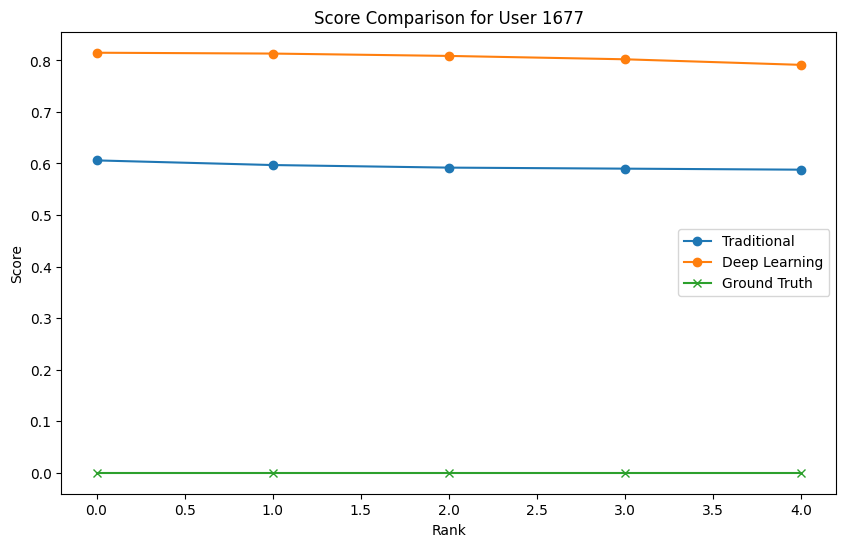

In [34]:


# Cell 9: Statistical comparison (fixed and enhanced)
def compare_recommendation_methods(user_idx, prompt):
    # Traditional method
    trad_matches, trad_explanations = recommend_with_prompt(user_idx, prompt)
    trad_scores = [float(exp.split("Score=")[1].split(",")[0]) for exp in trad_explanations]
    
    # Deep learning method
    deep_matches, deep_scores = recommend_with_prompt_deep(user_idx, prompt)
    deep_scores = [s[1] for s in deep_scores]
    
    # Simulated ground truth (more realistic: based on keyword overlap + user_type match)
    ground_truth = []
    for idx in range(5):  # Top 5 matches
        candidate = df.iloc[idx]
        headline_keywords = candidate['Headline'].lower().split()
        prompt_keywords, _ = analyze_prompt(prompt)
        overlap = len(set(prompt_keywords) & set(headline_keywords)) / len(prompt_keywords)
        type_bonus = 0.2 if df.iloc[user_idx]['user_type'] == 'student' and candidate['user_type'] == 'alumni' else 0
        ground_truth.append(overlap + type_bonus)
    
    # Metrics
    trad_mae = np.mean(np.abs(np.array(trad_scores) - ground_truth))
    deep_mae = np.mean(np.abs(np.array(deep_scores) - ground_truth))
    trad_rmse = np.sqrt(np.mean((np.array(trad_scores) - ground_truth) ** 2))
    deep_rmse = np.sqrt(np.mean((np.array(deep_scores) - ground_truth) ** 2))
    
    stats = pd.DataFrame({
        "Method": ["Traditional", "Deep Learning"],
        "MAE": [trad_mae, deep_mae],
        "RMSE": [trad_rmse, deep_rmse],
        "Avg Score": [np.mean(trad_scores), np.mean(deep_scores)],
        "Std Dev": [np.std(trad_scores), np.std(deep_scores)]
    })
    display(stats)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(range(5), trad_scores, label='Traditional', marker='o')
    plt.plot(range(5), deep_scores, label='Deep Learning', marker='o')
    plt.plot(range(5), ground_truth, label='Ground Truth', marker='x')
    plt.title(f"Score Comparison for User {user_idx}")
    plt.xlabel("Rank")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

print("Comparing recommendation methods...")
compare_recommendation_methods(1677, "Any Android Developer to connect with?")